In [1]:
# Sample code for MPS of a vector representing an image
# 2020 Oct. Tsuyoshi Okubo
# 2020 Dec. Add appendix

In this code, we perform a matrix product (a tensor train) decomposition for a vector representing an image.
The input parameters are
* filename: file name of the input image
* $N$ : number of "site"
* $m$ : "local dimension". (Total vector dimension is $m^N$.)
* chi_max : maximum bond dimension of MPS

The original $(X, Y)$ pixel image is firstly transformed into the gray scale. Then, from it we cut $(m^{N/2}, m^{N/2})$ region for even $N$. In the case of odd $N$, we cut $(m^{(N+1)/2}, m^{(N-1)/2})$. We can consider the trimmed image as am $m^N$ dimensional vector, which is used as the input vector in the following analysis.

By using the input vector, we construct the exact matrix product state (tensor train decomposition). Then we truncate the each bond dimension to "chi_max" and make an approximated vector.
Finally, the code calculate the distance between the exact vector and the approximated vector. 

In the appedix, we calculate chi_max dependece of the distance.

In [2]:
import numpy as np
import scipy.linalg as linalg
import argparse
import copy
import MPS
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image ## Python Imaging Library

In [3]:
## Set parameters
filename = "sample.jpg"
N = 16 ## set "system size" N 
m = 2 ## vector size m: total dimension is m^N
chi_max = 20 ## maximum bond dimension at truncation


In [4]:
img = Image.open(filename) ## load image
img_gray = img.convert("L") ## convert to grayscale

img_x, img_y = img_gray.size
if N % 2 == 0:
    new_x = m**(N//2)
    new_y = m**(N//2)
else:
    new_x = m**((N+1)//2)
    new_y = m**((N-1)//2)

## trimming
img_gray_trimmed = img_gray.crop(((img_x - new_x)//2, (img_y - new_y)//2, (img_x + new_x)//2, (img_y + new_y)//2))

img_gray_trimmed.save("./gray_trimmed.png") ## save grayscale image


print("Parameters: N, m, chi_max = "+repr(N)+", "+repr(m)+ ", "+repr(chi_max))
print("Input file: " + filename) ## print array shape
print("Original size: "+repr(img_gray.size)) ## print array shape
print("Trimmed size: " +repr(img_gray_trimmed.size))

Parameters: N, m, chi_max = 16, 2, 20
Input file: sample.jpg
Original size: (1024, 768)
Trimmed size: (256, 256)


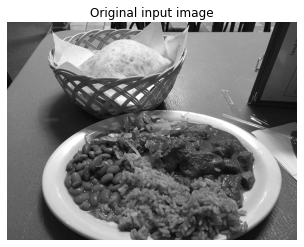

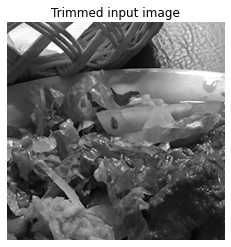

In [5]:
plt.axis("off")
plt.title("Original input image")
plt.imshow(img_gray,cmap='gray')
plt.show()

plt.axis("off")
plt.title("Trimmed input image")
plt.imshow(img_gray_trimmed,cmap='gray')
plt.show()

In [6]:
## Main calculation
## make vector
img_vec = np.array(img_gray_trimmed,dtype=float).flatten()

## normalization
img_norm = np.linalg.norm(img_vec)
img_vec /= img_norm


In [7]:
## Make exact MPS (from "left")
Tn = []
lam = [np.ones((1,))]
lam_inv = 1.0/lam[0]
R_mat = img_vec[:].reshape(m,m**(N-1))

chi_l=1
for i in range(N-1):
    U,s,VT = linalg.svd(R_mat,full_matrices=False)
    chi_r = s.size

    Tn.append(np.tensordot(np.diag(lam_inv),U.reshape(chi_l,m,chi_r),(1,0)).transpose(1,0,2))
    lam.append(s)
    lam_inv = 1.0/s
    R_mat = np.dot(np.diag(s),VT).reshape(chi_r*m,m**(N-i-2))
    chi_l = chi_r
Tn.append(VT.reshape(m,m,1).transpose(1,0,2))
lam.append(np.ones((1,)))


In [8]:
## Truncation to chi_max

Tn_ex = copy.deepcopy(Tn)
lam_ex = copy.deepcopy(lam)

#Tn_ex = Tn
#lam_ex = lam
for i in range(N-1):
    chi = min(chi_max,lam[i+1].shape[0])
    lam[i+1]=lam[i+1][:chi]
    Tn[i]=Tn[i][:,:,:chi]
    Tn[i+1]=Tn[i+1][:,:chi,:]

print("Truncation: chi_max = "+repr(chi_max))


Truncation: chi_max = 20


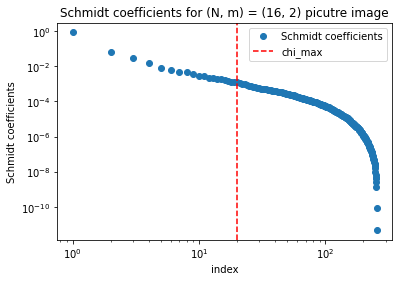

In [9]:
## plot Schmidt coefficient at N/2
## Red line indicates the position of chi_max

plt.title("Schmidt coefficients for "+"(N, m) = ("+repr(N)+", "+repr(m)+") picutre image")
plt.plot(np.arange(len(lam_ex[N//2]))+1,lam_ex[N//2]**2,"o",label="Schmidt coefficients")
plt.axvline([chi_max],0,1,  c="red", linestyle='dashed', label="chi_max") ## position of chi_max
plt.xlabel("index")
plt.xscale("log")
plt.ylabel("Schmidt coefficients")
plt.yscale("log")
plt.legend()
plt.show()



In [10]:
## Distance between Exact MPS and truncated MPS

vec_ex = MPS.remake_vec(Tn_ex,lam_ex)
vec_ap = MPS.remake_vec(Tn,lam)
print("Distance between exact and truncated MPS = "+repr(linalg.norm(vec_ex - vec_ap)))


Distance between exact and truncated MPS = 0.18728957286061443


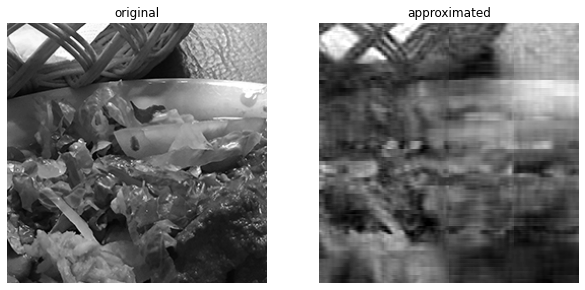

In [11]:
## Original and Approximated image
img_ex = Image.fromarray(np.uint8(np.clip(img_norm*vec_ex.reshape((new_y,new_x)),0,255)))
img_ap = Image.fromarray(np.uint8(np.clip(img_norm*vec_ap.reshape((new_y,new_x)),0,255)))

img_ap.save("./gray_trimmed_ap.png") ## save grayscale image

plt.figure(figsize=(2 * new_x*0.02,new_y*0.02))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("original")
plt.imshow(img_ex,cmap='gray')

plt.subplot(1,2,2)
plt.axis("off")
plt.title("approximated")
plt.imshow(img_ap,cmap='gray')
plt.show()

## Appendix: bond dimension dependence 

In this appendix, we calculate the distance between the original and approximated vector as a function of chi_max.   
We use the same original vector as the main part.   
You can set maxmum and minimum value of chi_max for the calculation.


In [12]:
min_chi_max = 10
max_chi_max = 260 ## maximum bond dimension of the exact MPS is m**(N/2)
d_chi_max = 10

In [13]:
chi_max_list = np.arange(min_chi_max, max_chi_max+1, d_chi_max, dtype=int)
chi_list = np.ones((N+1,),dtype=int)
vec_ex = MPS.remake_vec(Tn_ex,lam_ex)

distances=[]
for chi_max in chi_max_list:
    for i in range(N-1):
        chi = min(chi_max,lam_ex[i+1].shape[0])
        chi_list[i+1] = chi
    lam = [np.ones((1,))]
    Tn = []
    for i in range(N):
        lam.append(lam_ex[i+1][:chi_list[i+1]])
        Tn.append(Tn_ex[i][:,:chi_list[i],:chi_list[i+1]])
    vec_ap = MPS.remake_vec(Tn,lam)
    distances.append(linalg.norm(vec_ex - vec_ap))

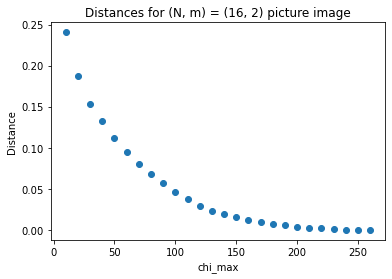

In [14]:
## plot distances

plt.title("Distances for "+"(N, m) = ("+repr(N)+", "+repr(m)+") picture image")
plt.plot(chi_max_list,distances,"o")
plt.xlabel("chi_max")
plt.ylabel("Distance")
#plt.yscale("log")
plt.show()

